## Transfer Learning for Multi-Class Image Classification

### Image classification of Oxford-IIIT Pets dataset using Inception V3 model:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/)

## (1) Initial Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/AI Project')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from keras import callbacks

In [4]:
# Check Tensorflow version
tf. __version__

'2.17.1'

___
## (2) Import Data

#### Load and split the raw image data
- We load the pets dataset (named as `oxford_iiit_pet` in `tfds`) as a `tf.data.Dataset` object, and the raw dataset has two sets: train and test
- The train/val split is set as 80:20 ratio, and we also ensure the images are shuffled

In [5]:
%pip install tensorflow_datasets==4.9.3

In [6]:
(train_raw, val_raw, test_raw), ds_info = tfds.load(name='oxford_iiit_pet',
                                                    split=['train[:80%]',
                                                          'train[80%:]',
                                                          'test'],
                                                    shuffle_files=True,
                                                    as_supervised=True, # Returns (image, label)
                                                    with_info=True # To retrieve dataset info and label names
                                                    )

4.0.0
Using /root/tensorflow_datasets/oxford_iiit_pet/3.2.0 instead.


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteIJJTLD/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteIJJTLD/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [7]:
ds_info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir=PosixGPath('/tmp/tmpjlz43siktfds'),
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        '

### Display several examples of the image dataset (from the train set) using the in-built `tfds.show_examples` function

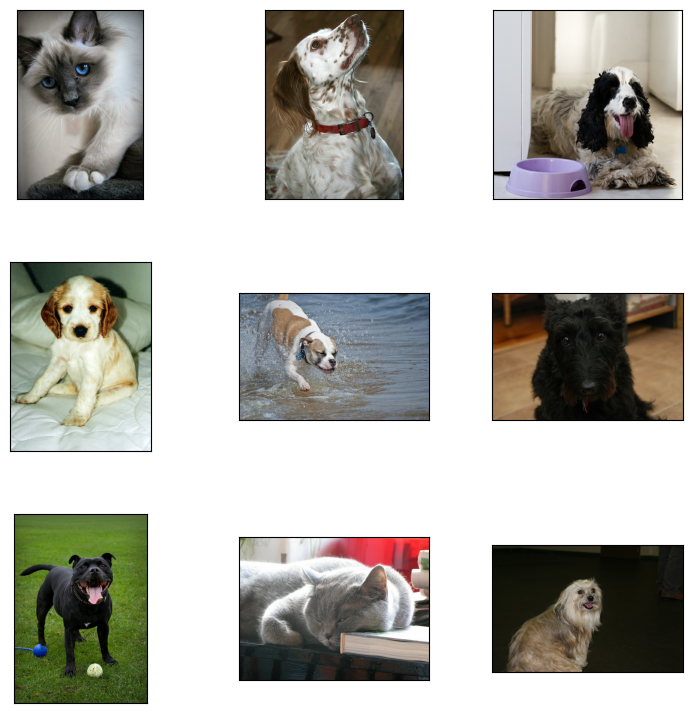

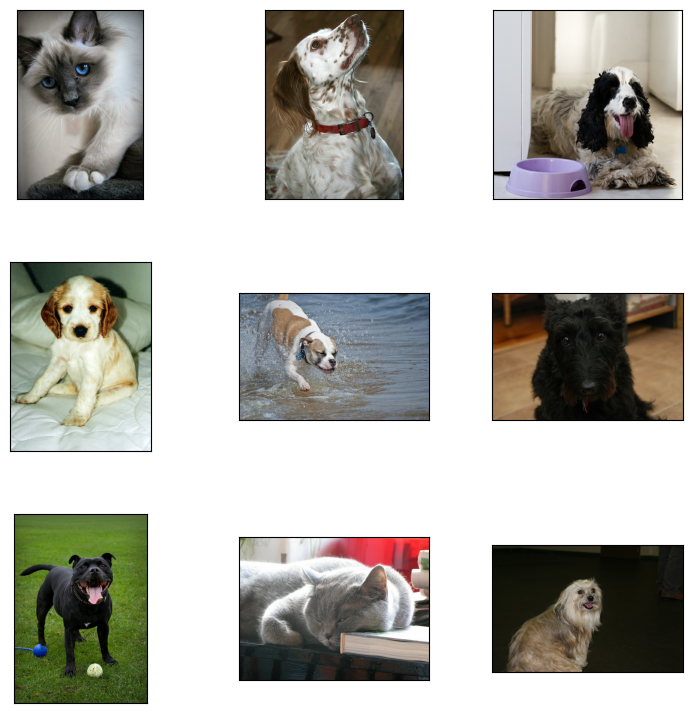

In [8]:
tfds.show_examples(train_raw, ds_info, image_key='image')

___
## (3) Understanding the dataset
#### Retrieve relevant counts to better understand the dataset we will be working on

In [9]:
# Get number of classes
num_classes = ds_info.features['label'].num_classes
print('Number of classes:', num_classes)

for name in ds_info.features['label'].names:
        print(name, ds_info.features['label'].str2int(name))

Number of classes: 37
Abyssinian 0
american_bulldog 1
american_pit_bull_terrier 2
basset_hound 3
beagle 4
Bengal 5
Birman 6
Bombay 7
boxer 8
British_Shorthair 9
chihuahua 10
Egyptian_Mau 11
english_cocker_spaniel 12
english_setter 13
german_shorthaired 14
great_pyrenees 15
havanese 16
japanese_chin 17
keeshond 18
leonberger 19
Maine_Coon 20
miniature_pinscher 21
newfoundland 22
Persian 23
pomeranian 24
pug 25
Ragdoll 26
Russian_Blue 27
saint_bernard 28
samoyed 29
scottish_terrier 30
shiba_inu 31
Siamese 32
Sphynx 33
staffordshire_bull_terrier 34
wheaten_terrier 35
yorkshire_terrier 36


In [10]:
num_train_examples = tf.data.experimental.cardinality(train_raw).numpy()
num_val_examples = tf.data.experimental.cardinality(val_raw).numpy()
num_test_examples = tf.data.experimental.cardinality(test_raw).numpy()

print('Number of training samples:', num_train_examples)
print('Number of validation samples:', num_val_examples)
print('Number of test samples:', num_test_examples)

Number of training samples: 2944
Number of validation samples: 736
Number of test samples: 3669


In [11]:
def get_value_counts(ds):
    label_list = []
    for images, labels in ds:
        label_list.append(labels.numpy())

    label_counts = pd.Series(label_list).value_counts(sort=True)

    print(label_counts)

In [12]:
get_value_counts(train_raw)

2     87
26    86
19    86
36    86
13    85
35    84
4     83
18    83
20    83
21    82
5     82
1     82
32    82
34    82
16    81
9     81
23    81
30    80
27    80
3     80
22    80
14    79
15    79
31    78
10    78
25    77
7     77
8     76
6     76
24    76
17    76
0     76
29    74
12    73
28    72
11    71
33    70
Name: count, dtype: int64


In [13]:
get_value_counts(val_raw)

33    30
28    28
29    26
8     24
24    24
6     24
0     24
17    24
12    23
25    23
11    22
10    22
31    22
15    21
14    21
3     20
27    20
30    20
23    19
16    19
9     19
7     19
1     18
21    18
5     18
34    18
4     17
18    17
32    17
20    17
22    16
35    16
13    15
19    14
36    14
26    14
2     13
Name: count, dtype: int64


In [14]:
# Function to obtain the name for the label integer
get_label_name = ds_info.features['label'].int2str

In [15]:
# Build the custom function to display image and label name
def view_single_image(ds):
    # image, label = next(iter(ds))
    # print('Image shape: ', image.shape)
    # plt.imshow(image)
    # _ = plt.title(get_label_name(label))
    # Display the first instance of the dataset
    for example in ds.take(1):
        image, label = example
        print('Image shape:', image.shape)
        print('Label name: ', get_label_name(label))

        # Plot the image
        plt.figure()
        plt.imshow(image)
        plt.title('Label: ' + str(label.numpy()))
        plt.axis('on')
        plt.show()

Image shape: (333, 500, 3)
Label name:  miniature_pinscher


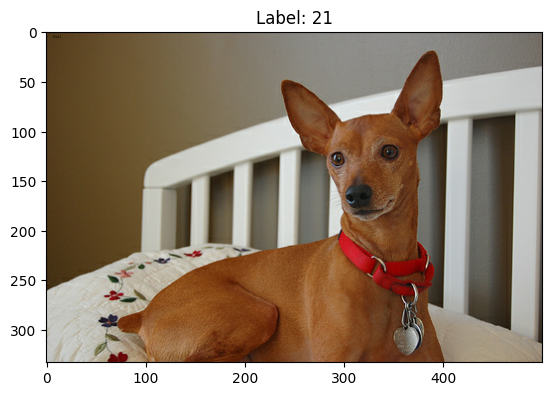

In [16]:
view_single_image(train_raw)

___
## (4) Data Preparation

### (i) Image Resizing
- Because the raw images come in different sizes, we want to resize them to the same size before parsing them into the neural network later
- Both the length and width to be 299 pixels (which is what Inception expects)

In [17]:
IMG_SIZE_INCEPTION = 299

train_ds_inception = train_raw.map(lambda x, y: (tf.image.resize(x, (IMG_SIZE_INCEPTION, IMG_SIZE_INCEPTION)), y))
val_ds_inception = val_raw.map(lambda x, y: (tf.image.resize(x, (IMG_SIZE_INCEPTION, IMG_SIZE_INCEPTION)), y))
test_ds_inception = test_raw.map(lambda x, y: (tf.image.resize(x, (IMG_SIZE_INCEPTION, IMG_SIZE_INCEPTION)), y))

___
### (ii) Label One-hot Encoding
- There are 37 classes (i.e. pet breeds) in the dataset that we are using for multi-class image classification
- As such, we proceed to one-hot encode the labels so that we get a output vector of length 37

In [18]:
def one_hot_encode(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

In [19]:
train_ds_inception = train_ds_inception.map(one_hot_encode)
val_ds_inception = val_ds_inception.map(one_hot_encode)
test_ds_inception = test_ds_inception.map(one_hot_encode)

#### Let's have a look at what our dataset object looks like currently

In [20]:
train_ds_inception

<_MapDataset element_spec=(TensorSpec(shape=(299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(37,), dtype=tf.float32, name=None))>

From the printout, we can see that each dataset object (i.e., `train_ds`, `val_ds`, and `test_ds`) has two components each:
- Images of shape (224,224,3)
- Label vector of shape (37,)

### (iii) Image (Data) Augmentation
- Image augmentation artificially creates training images through different ways of processing or combination of multiple processing, such as random rotation, shifts, shear and flips, etc.

In [21]:
data_augmentation = keras.Sequential(
    [layers.RandomFlip('horizontal'),
     layers.RandomRotation(factor=(-0.025, 0.025)),
     layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
     layers.RandomContrast(factor=0.1),
     ])

#### View effects of augmentation

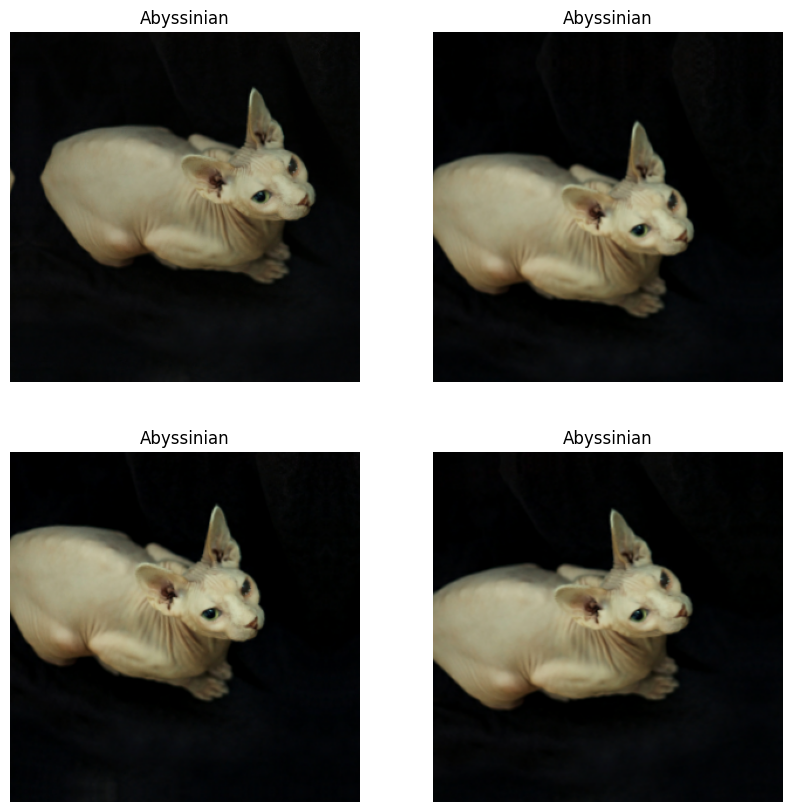

In [22]:
for image, label in train_ds_inception.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(4):
        ax = plt.subplot(2, 2, i+1)
        aug_img = data_augmentation(tf.expand_dims(image, axis=0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title(get_label_name(int(label[0])))
        plt.axis("off")

### (iv) Batching and Prefetching
- We can batch the data and use prefetching to optimize loading speed and model efficiency
- A batch size of 32 is a good value to start with
- The number of elements to prefetch can be automatically determined by making use of `tf.data.AUTOTUNE`, which prompt the runtime to tune the value dynamically for us.

In [23]:
BATCH_SIZE = 32

In [24]:
train_ds_inception = train_ds_inception.batch(batch_size=BATCH_SIZE,
                          drop_remainder=True).prefetch(tf.data.AUTOTUNE)

val_ds_inception = val_ds_inception.batch(batch_size=BATCH_SIZE,
                      drop_remainder=True).prefetch(tf.data.AUTOTUNE)

test_ds_inception = test_ds_inception.batch(batch_size=BATCH_SIZE,
                        drop_remainder=True).prefetch(tf.data.AUTOTUNE)

___
## (5) Model Setup

### (i) Setup base model

In [25]:
inception_v3 = keras.applications.InceptionV3(
                            include_top=False, # Exclude ImageNet classifier at the top.
                            weights="imagenet",
                            input_shape=(IMG_SIZE_INCEPTION, IMG_SIZE_INCEPTION, 3)
                            )

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### (ii) Freeze pre-trained weights of the base model
- When a trainable weight becomes non-trainable, its value is no longer updated during training.

In [26]:
# Freeze the base_model
inception_v3.trainable = False

### (iii) Modify inputs
- We pre-process the inputs (i.e., images) so that they are compatible with what the pre-trained ResNet50v2 architecture expects

In [27]:
# Create new model on top
inputs_inception = keras.Input(shape=(IMG_SIZE_INCEPTION, IMG_SIZE_INCEPTION, 3))
x_inception = data_augmentation(inputs_inception)
x_inception = keras.applications.inception_v3.preprocess_input(x_inception)
x_inception = inception_v3(x_inception, training=False)

### (iv) Rebuild top layers
- Given that we have removed the top ImageNet classifier layer of InceptionV3, we can now build a custom top layer that is specific to our image classification task i.e., classify an image based on the 37 different pet breeds types.

In [28]:
# Rebuild top layers for Inception V3 model
x_inception = layers.GlobalAveragePooling2D()(x_inception)
x_inception = layers.BatchNormalization()(x_inception)
x_inception = layers.Dropout(0.2)(x_inception)  # Regularize with dropout

outputs_inception = layers.Dense(num_classes, activation="softmax", name="pred")(x_inception)

model_inception = keras.Model(inputs_inception, outputs_inception, name="InceptionV3")

#### Display model summary

In [29]:
model_inception.summary()

Model: "InceptionV3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_v3 (Functional)            │ (None, 8, 8, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_94               │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pred (Dense)                         │ (None, 37)                  │          75,813 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,886,789 (83.49 MB)

 Trainable params: 79,909 (312.14 KB)

 Non-trainable params: 21,806,880 (83.19 MB)

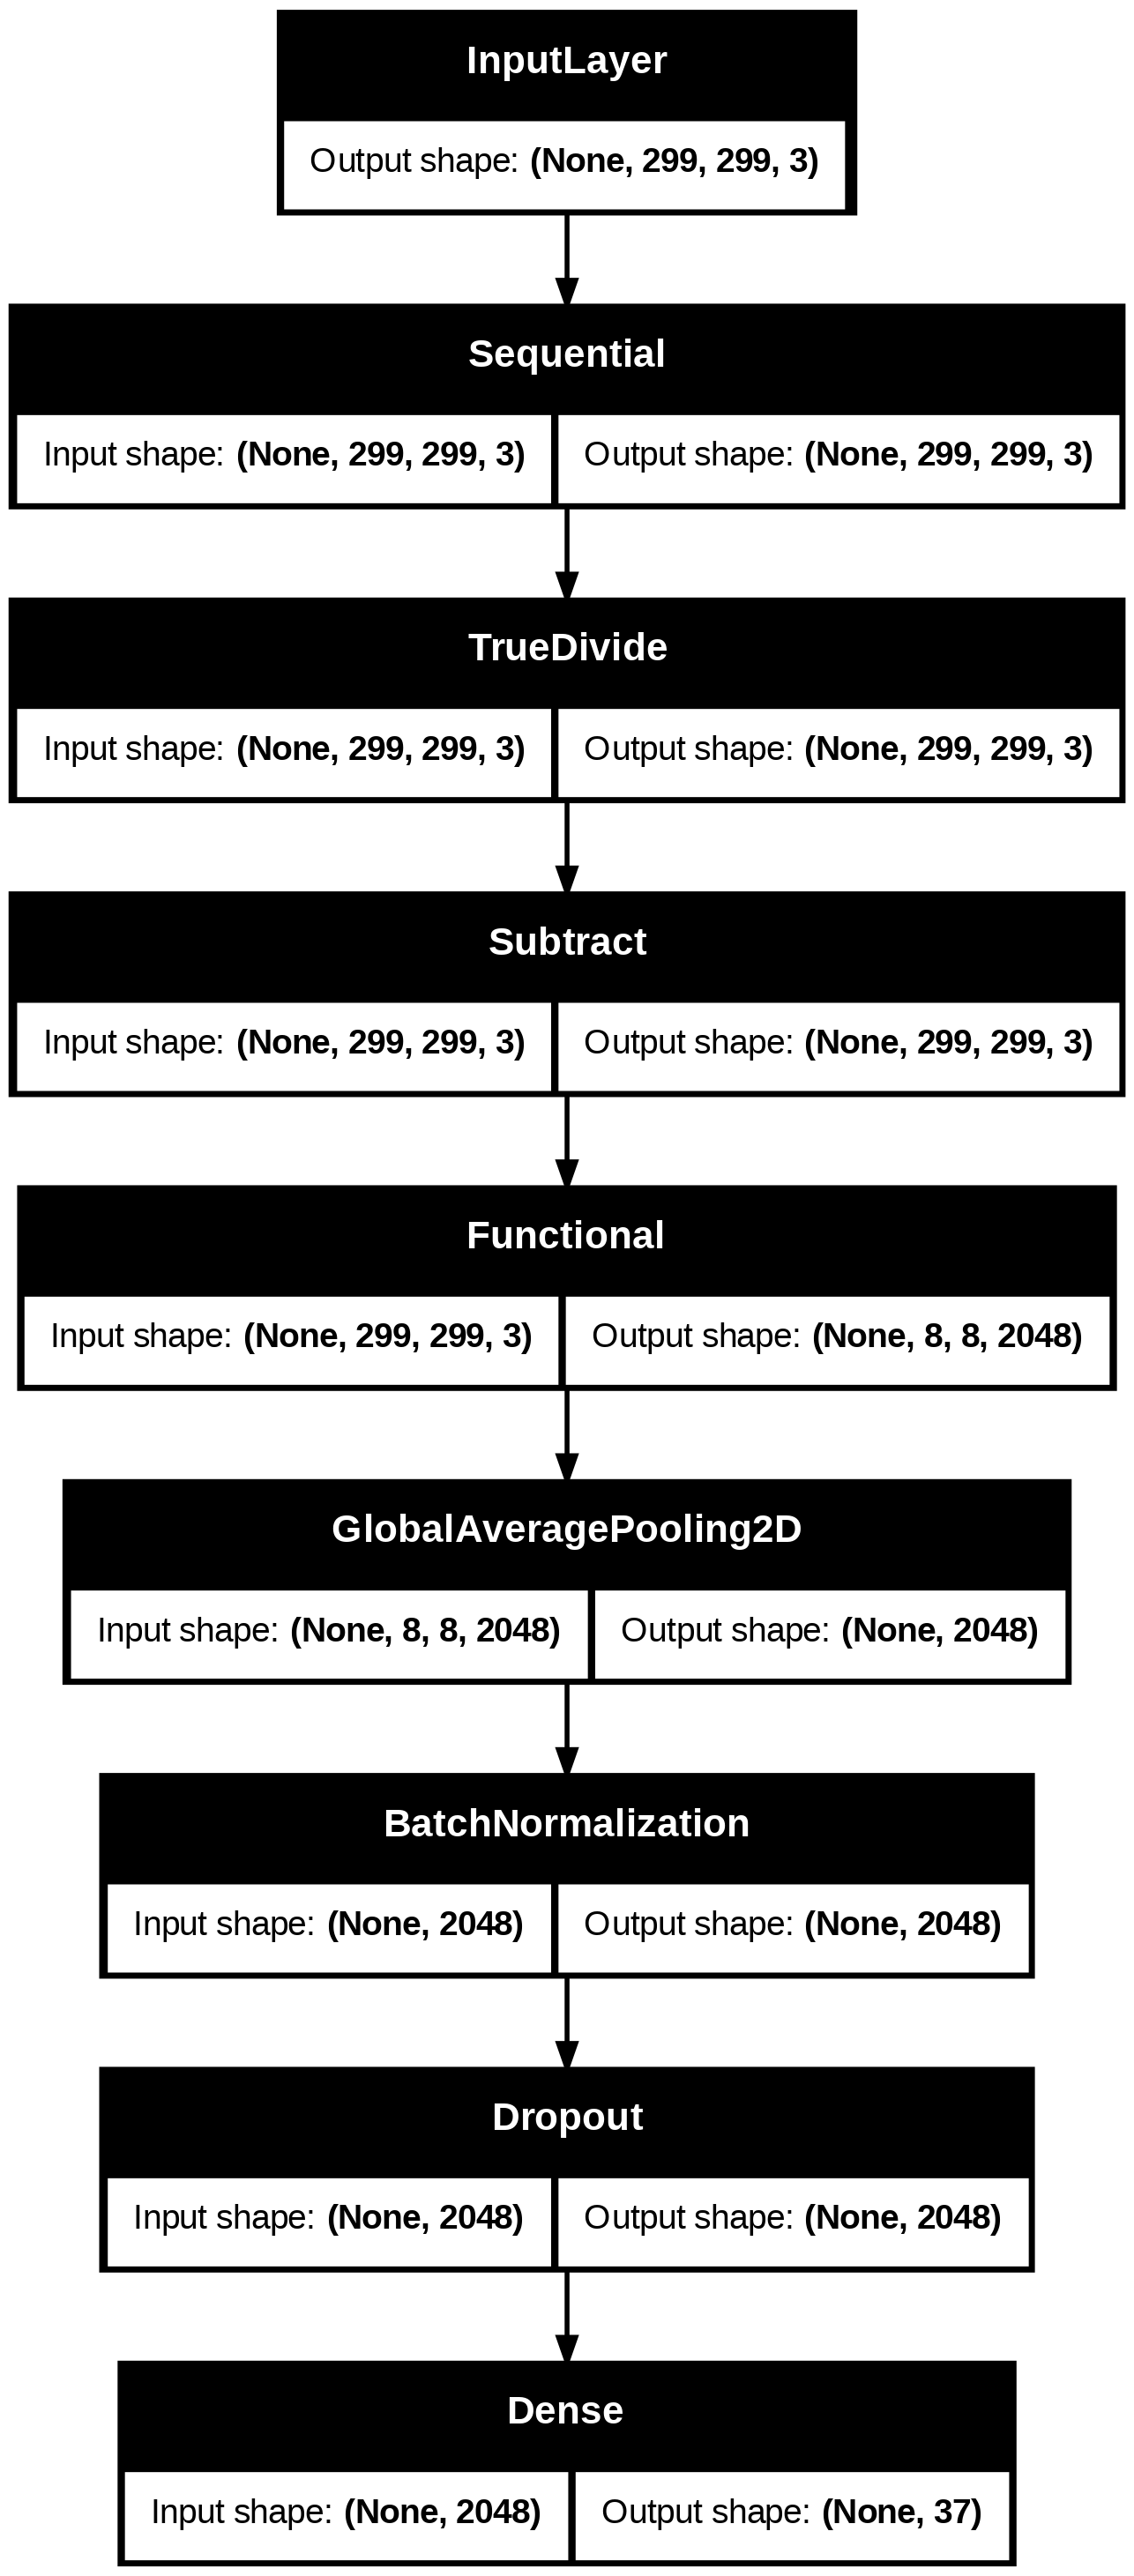

In [30]:
keras.utils.plot_model(model_inception, show_shapes=True)

#### Compile model
- Utilize the commonly used Adam optimizer (leave the learning rate as default)
- Since it is a multi-class classification, we will use categorical cross entropy and categorical accuracy as our loss and performance metric respectively

In [31]:
model_inception.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=[keras.metrics.CategoricalAccuracy()]
             )

#### Include early stopping
- Prevent overfitting

In [32]:
earlystopping = callbacks.EarlyStopping(monitor='val_loss',
                                        mode='min',
                                        patience=5,
                                        restore_best_weights=True)

___
## (6) Model Training

#### Fit model
- Ensure that the Google Colab runtime using GPU hardware accelerator
- Fit the model over the training dataset for 15 epochs
- Store the training output as a variable called `history`

In [33]:
tf.config.optimizer.set_jit(True)

In [34]:
EPOCHS = 15

history = model_inception.fit(train_ds_inception, epochs=EPOCHS, validation_data=val_ds_inception, verbose=1,
                    callbacks =[earlystopping])

Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 46s 250ms/step - categorical_accuracy: 0.5780 - loss: 1.6817 - val_categorical_accuracy: 0.8967 - val_loss: 0.6825
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 169ms/step - categorical_accuracy: 0.9088 - loss: 0.2550 - val_categorical_accuracy: 0.9090 - val_loss: 0.3463
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 168ms/step - categorical_accuracy: 0.9428 - loss: 0.1685 - val_categorical_accuracy: 0.9212 - val_loss: 0.2843
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 208ms/step - categorical_accuracy: 0.9531 - loss: 0.1183 - val_categorical_accuracy: 0.9226 - val_loss: 0.2702
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 168ms/step - categorical_accuracy: 0.9812 - loss: 0.0808 - val_categorical_accuracy: 0.9226 - val_loss: 0.2852
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 166ms/step - categorical_accuracy: 0.9719 - loss: 0.0761 - val_categorical_accuracy: 0.9226 - val_loss: 0.2888
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 166ms/step - categorical_accuracy: 0.981

In [35]:
model_inception.save('Models/Inception_V3.keras')

#### Plot the accuracy of training and validation sets over epochs

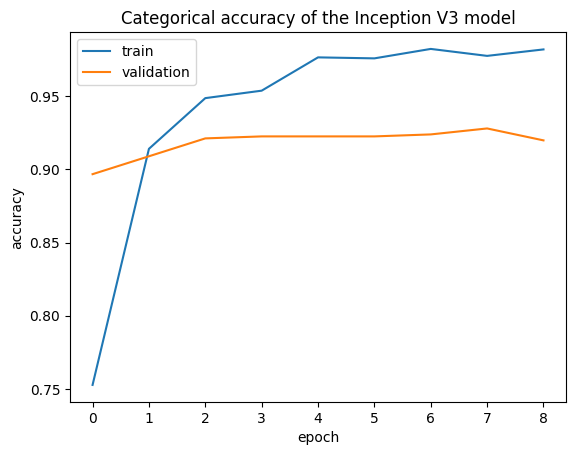

In [36]:
def plot_hist(hist):
    plt.plot(hist.history['categorical_accuracy'])
    plt.plot(hist.history['val_categorical_accuracy'])
    plt.title('Categorical accuracy of the Inception V3 model')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

plot_hist(history)

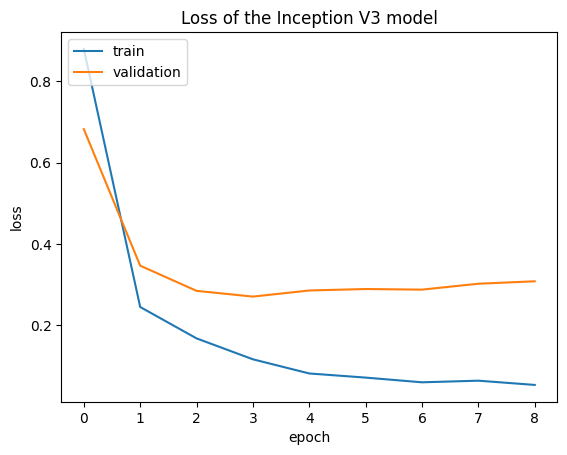

In [37]:
def plot_hist(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Loss of the Inception V3 model')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

plot_hist(history)

___
## (7) Model Evaluation

In [38]:
preds_inception = model_inception.predict(test_ds_inception)

114/114 ━━━━━━━━━━━━━━━━━━━━ 19s 117ms/step


#### Evaluate model on test dataset

In [39]:
result_inception = model_inception.evaluate(test_ds_inception)

114/114 ━━━━━━━━━━━━━━━━━━━━ 16s 137ms/step - categorical_accuracy: 0.9016 - loss: 0.3283


#### Display results

In [40]:
dict(zip(model_inception.metrics_names, result_inception))

{'loss': 0.3183448612689972, 'compile_metrics': 0.9035087823867798}

## (8) Run inference on new data

In [42]:
from keras.preprocessing import image

# Load the saved model
loaded_model = keras.models.load_model('Models/Inception_V3.keras')

# Function to preprocess the uploaded image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(299, 299))
    img_array = image.img_to_array(img)
    plt.imshow(img_array/255)
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match model input shape
    return img_array

# Function to make predictions
def predict_image(img_array):
    predictions = loaded_model.predict(img_array)
    predicted_class = np.argmax(predictions[0])  # Get the index of the class with highest probability
    return predicted_class

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Predicted class index: 25
Predicted class: pug


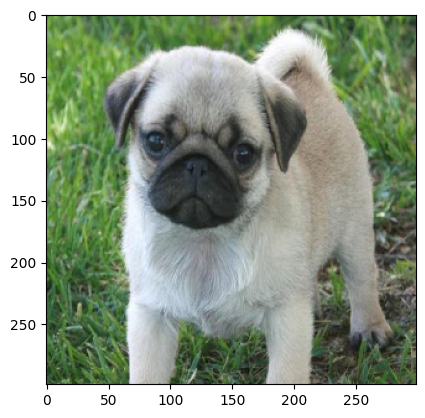

In [43]:
uploaded_file_path = "Samples/pug.jpg"

# Preprocess the uploaded image
preprocessed_img = preprocess_image(uploaded_file_path)

class_names = ds_info.features['label'].names

# Make predictions
predicted_class = predict_image(preprocessed_img)

# Display the prediction
print("Predicted class index:", predicted_class)

# Function to map class index to class name
def get_class_name(class_index):
    return class_names[class_index]

# Example usage:
predicted_class_name = get_class_name(predicted_class)

# Print the actual name of the predicted class
print("Predicted class:", predicted_class_name)

## (9) Confusion Matrix and Classification Report

In [44]:
from sklearn.metrics import classification_report, confusion_matrix
from seaborn import heatmap
import seaborn as sns

In [45]:
# Assuming 'model' is your trained model and 'test_ds' is your test dataset
y_true = []
y_pred = []

for images, labels in test_ds_inception:
    predictions = model_inception.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(predictions, axis=1))

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85m

Classification Report:
                             precision    recall  f1-score   support

                Abyssinian       0.76      0.91      0.83        98
          american_bulldog       0.74      0.92      0.82       100
 american_pit_bull_terrier       0.91      0.49      0.64        99
              basset_hound       0.98      0.94      0.96       100
                    beagle       0.94      0.95      0.94        98
                    Bengal       0.67      0.73      0.70        99
                    Birman       0.76      0.69      0.72       100
                    Bombay       0.92      0.92      0.92        88
                     boxer       0.93      0.89      0.91        98
         British_Shorthair       0.91      0.71      0.80       100
                 chihuahua       0.95      0.95      0.95        99
              Egyptian_Mau       0.80      0.85      0.83        95
    english_cocker_spaniel       0.97      0.98      0.98       100
            english_set

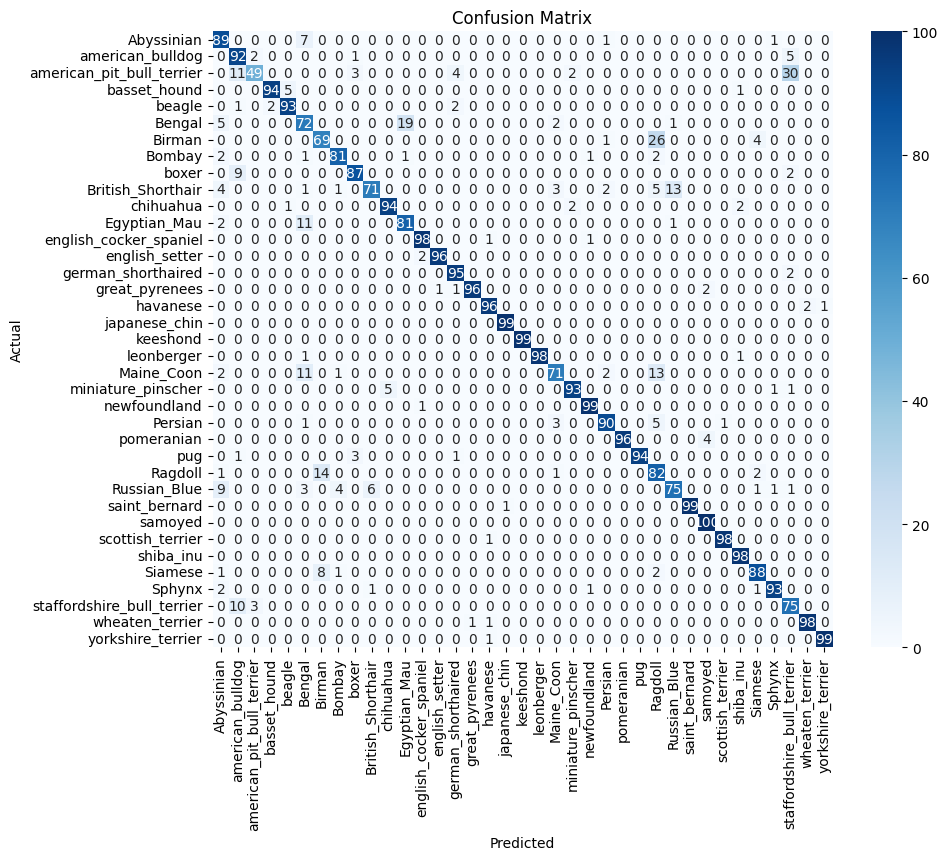

In [46]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Print the classification report
class_names = ds_info.features['label'].names  # Ensure this list is available or manually define it
class_report = classification_report(y_true, y_pred, target_names=class_names)
print('Classification Report:\n', class_report)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [47]:
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, f1_score

# Assuming y_true are the true labels/values and y_pred are the predicted labels/values
accuracy = accuracy_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)  # squared=False returns RMSE
f1 = f1_score(y_true, y_pred, average='weighted')

# Print the evaluation metrics

print("Accuracy:", accuracy)
print("MAE:", mae)
print("RMSE:", rmse)
print("F1:", f1)

Accuracy: 0.9037828947368421
MAE: 1.4967105263157894
RMSE: 5.748760354549065
F1: 0.9036095523597582


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
